## 데이터 Import

In [227]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.decomposition import KernelPCA 
from sklearn.svm import SVC 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
import pandas as pd
import plotly.express as px
from torch import optim
import torch
from torch import nn
from tqdm.notebook import tqdm

## 데이터 불러오기

In [184]:
olive_data = fetch_olivetti_faces()

## 이미지 데이터
n_samples, h, w = olive_data.images.shape
data_size = h*w
X = olive_data.images.reshape(-1, data_size)
print("이미지 갯수[{}],  이미지 가로[{}],  이미지 세로[{}]  가로X세로[{}]".format(n_samples, h, w, data_size))

## Label 데이터
y = olive_data.target
n_classes = len(set(y))
print("클래스 개수[{}]".format(n_classes))

이미지 갯수[400],  이미지 가로[64],  이미지 세로[64]  가로X세로[4096]
클래스 개수[40]


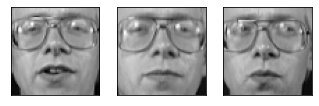

In [185]:
## 데이터 시각화  
def plot_gallery(images, item_index, n_col = 3, h=64, w=64, title=None): 
    if len(item_index) < n_col:
        n_row = len(item_index)
    
    plt.figure(figsize =(1.8 * n_col, 2.4))
    item_index = item_index[:n_col]
    #plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35) 
    for i in range(n_col): 
        plt.subplot(1, n_col, i + 1) 
        plt.imshow(images[item_index[i]].reshape(h, w), cmap = plt.cm.gray) 
        plt.xticks(()) 
        plt.yticks(())
    if title is not None:
        plt.suptitle(title)
        
## 얼굴 선택
sample_index = 1
n_col = 3
itemindex = np.where(y==sample_index)[0]

## 얼굴 plot
plot_gallery(X, itemindex, n_col, h, w)

In [187]:
## 데이터 나누기 5:5
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size = 0.5, random_state = 42, stratify=y) 
print("학습용 데이터[{}], 검증용 데이터[{}]".format( 
        y_train.shape[0], y_test.shape[0])) 

학습용 데이터[200], 검증용 데이터[200]


## Kernel-PCA & Linear-SVM 파라미터 탐색

In [188]:
## Pipe Line 구성
pipe = Pipeline([('pca', KernelPCA(kernel="poly")), ('svc', SVC(class_weight ='balanced'))])

In [189]:
## 탐색 할 hyper-paramter 를 setting
param_grid = {
    'pca__n_components': [20, 40, 60, 80, 100, 120, 140], ## Kernel-PCA 파라미터(n_components)
    'pca__degree': [2, 3, 4, 5], ## Kernel-PCA 파라미터(degree)
    'svc__C': [1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1, 8e-1, 9e-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1e1], ## SVM 파라미터
} 

In [190]:
clf = GridSearchCV(pipe, param_grid=param_grid)

In [191]:
%%time
clf = clf.fit(X_train, y_train) 

Wall time: 1min 41s


In [192]:
print("Grid Search를 이용하여 탐색한 Best hyper-parameter") 
print(clf.best_estimator_) 

Grid Search를 이용하여 탐색한 Best hyper-parameter
Pipeline(steps=[('pca', KernelPCA(degree=2, kernel='poly', n_components=60)),
                ('svc', SVC(C=2, class_weight='balanced'))])


In [193]:
## 결과를 Dataframe으로 도출
summary = pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

In [194]:
## 시각화
fig = px.bar(summary, x="pca__n_components", y="Accuracy", color="pca__n_components",
  animation_frame="svc__C", animation_group="pca__n_components", range_y=[0.5,1])
fig.show()

In [228]:
## kenel-PCA & SVM 성능평가
y_pred = clf.predict(X_train) 
print("학습용 데이터 성능 [{}]".format(accuracy_score(y_train, y_pred)))

y_pred = clf.predict(X_test) 
print("검증용 데이터 성능 [{}]".format(accuracy_score(y_test, y_pred)))

학습용 데이터 성능 [1.0]
검증용 데이터 성능 [0.915]


## Neural Network 만들기

In [197]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size, class_size):
        super(NeuralNetwork, self).__init__()
        self.fc = nn.Sequential(
                    nn.BatchNorm1d(class_size),
                    nn.Linear(class_size, hidden_size),
                    nn.Tanh(),
                    nn.BatchNorm1d(hidden_size),
                    nn.Linear(hidden_size, class_size),
        )
    
    def forward(self, x, label=None):
        output = self.fc(x)
        return output
    

class FaceRecognition(object):
    def __init__(self, pca, svm, hidden_size, class_size, learning_rate=0.001):
        ## PCA, SVM setting
        self.pca = pca
        self.svm = svm
        
        self.class_size = class_size
        
        ## Neural Network 구축
        self.network = NeuralNetwork(hidden_size, class_size)
        
        ## loss
        #self.loss = nn.MSELoss()
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.network.parameters(), lr=learning_rate)
    
    ## 변환 함수
    def transform(self, x, label=None):
        ## PCA를 이용하여 데이터 변환
        projected_x = self.pca.transform(x) 
        
        ## SVM Score 산출
        class_scores = self.svm.decision_function(projected_x)
        
        ## Neural Network로 정규화
        tensor_score = torch.tensor(class_scores, dtype=torch.float)
        output = self.network(tensor_score)
        
        ## Label 이 있는 경우
        if label is not None:
            label = torch.tensor(label, dtype=torch.long)
            
            ## MSE를 이용하여 loss 계산
            return self.loss(output, label)
        
        return output
    
    ## 학습용 함수
    def fit(self, x, label):
        self.network.train()
        self.network.zero_grad()
        
        loss = self.transform(x, label)
        loss.backward()
        
        self.optimizer.step()
        return float(loss)
    
    ## 예측용 함수
    def predict(self, x):
        self.network.eval()
        with torch.no_grad():
            output = self.transform(x)
            
        output = output.argmax(dim=1).cpu().numpy()
        return output
    
    def raw_predict(self, x):
        ## PCA를 이용하여 데이터 변환
        projected_x = self.pca.transform(x) 
        
        ## SVM Score 산출
        return self.svm.predict(projected_x)

In [198]:
## Best SVM, PCA 모델 hyper-parameter setting
degree = clf.best_estimator_.get_params()['pca__degree']
n_components = clf.best_estimator_.get_params()['pca__n_components']
C = clf.best_estimator_.get_params()['svc__C']

svm = SVC(class_weight ='balanced', C=C)
pca = KernelPCA(kernel="poly", degree=degree, n_components=n_components)

## SVM, PCA Fitting
X_transformed = pca.fit_transform(X_train)
svm.fit(X_transformed, y_train)

SVC(C=2, class_weight='balanced')

In [224]:
## 최종 모델 구축
hidden_size = 10
model = FaceRecognition(pca, svm, hidden_size=n_classes , class_size=n_classes, learning_rate=0.002)

In [225]:
## training epoch 설정
epochs = 300

In [226]:
progress_bar = tqdm(range(epochs), desc='Epoch')
for epoch in progress_bar:
    loss = model.fit(X_train, y_train)
    progress_bar.set_postfix_str("loss [{}]".format(loss))

In [230]:
## 최종 모델 성능평가
y_train_pred = model.predict(X_train)
print("학습용 데이터 성능 [{}]".format(accuracy_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print("검증용 데이터 성능 [{}]".format(accuracy_score(y_test, y_test_pred)))

학습용 데이터 성능 [1.0]
검증용 데이터 성능 [0.8]
